<a href="https://colab.research.google.com/github/vvviet2908/FundamentalConceptsOfDataSecurity/blob/main/Ear_Recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread_collection
import cv2
import numpy as np
from keras.utils import np_utils 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_data(path):
    #creating a collection with the available images
    image = imread_collection(path)
    image_set = []
    for n in image:
        n = cv2.cvtColor(n,cv2.COLOR_RGB2GRAY)
        image_set.append(n)
    return image_set



def set_init(dataset, train_set_ratio, valid_set_ratio, test_set_ratio):

    
    #creating label set for all images
    label = np.empty(195*4)
    for i in range(195):
        label[i*4:i*4+4] = i
    label = label.astype(np.int)
    print(label.shape)
    label = np_utils.to_categorical(label, 195)#transfer to one-hot matrix
    
    train_num = 780*train_set_ratio
    train_num = int(train_num)
    valid_num = 780*valid_set_ratio
    valid_num = int(valid_num)
    test_num = 780*test_set_ratio
    test_num = int(test_num)
    
    train_data = np.empty((train_num,200,200))  
    train_label = np.empty((train_num,195))   
    valid_data = np.empty((valid_num, 200,200))   
    valid_label = np.empty((valid_num,195))   
    test_data = np.empty((test_num,200,200))  
    test_label = np.empty((test_num,195)) 
    
    x_test_tot = np.empty((valid_num + test_num,200,200))
    y_test_tot = np.empty((valid_num + test_num,195))
    
    train_data, x_test_tot, train_label, y_test_tot = train_test_split(dataset, label, test_size = 1-train_set_ratio)
    
#     valid_data, test_data, valid_label, test_label = train_test_split(x_test_tot, y_test_tot, test_size = test_set_ratio/(valid_set_ratio + test_set_ratio))
    
    train_data = np.asarray(train_data)
    x_test_tot = np.asarray(x_test_tot);
    valid_data = np.asarray(valid_data)
    test_data = np.asarray(test_data)
#     for i in range(195):
#         train_data[i * 2:i * 2 + 2] = image_set[i * 4:i * 4 + 2]
#         train_label[i * 2:i * 2 + 2] = label[i * 4:i * 4 + 2]
#         valid_data[i] = image_set[i * 4 + 2]
#         valid_label[i] = label[i * 4 + 2]
#         test_data[i] = image_set[i * 4 + 3]
#         test_label[i] = label[i * 4 + 3]
    result = [(train_data, train_label), (valid_data, valid_label),(test_data, test_label)]
    return result

def process_image(image_set, size, margin):
    data = []
    for n in image_set:
        n = n[margin[0]:margin[1], margin[2]:margin[3]]
        n = cv2.resize(n,(size,size))
        n = n / 255
        data.append(n)
    return data

In [ ]:
data_set = load_data('original/*.jpg')
data_final = process_image(data_set, size = 200, margin = [500,2500,500,3500])

In [ ]:
data_final = set_init(data_final, train_set_ratio = 0.99, valid_set_ratio = 0, test_set_ratio = 0)

(780,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras import regularizers
from keras.utils import generic_utils

def train(data, batch_size, epochs, nb_filters, pool_size, kernel_size, X_target):
    np.random.seed(1337)  # for reproducibility
    img_rows, img_cols = 200, 200  # width and height of pictures
    nb_classes = 195  # number of classes
    input_shape = (img_rows, img_cols,1) # dimenstion

    [(X_train, Y_train),[X_valid,Y_valid],[X_test,Y_test]] = data
    X_train = X_train[:,:,:,np.newaxis]  # add one dimenstion, keras required. total 4 dimension.
    print('dimension of data set：', X_train.shape,Y_train.shape)
    
    
    model = Sequential()
    model.add(Conv2D(32,kernel_size,padding = 'same', input_shape=input_shape,strides=1))  # convolution layer 1
    model.add(Activation('relu'))  
    model.add(AveragePooling2D(pool_size,strides=2))  # pooling layer
    model.add(Conv2D(64,kernel_size,strides=1))  # convolution layer 2
    model.add(Activation('relu'))    
    model.add(AveragePooling2D(pool_size,strides=2))  # pooling layer
    model.add(Flatten())  # 
    model.add(Dense(nb_classes)) # fully connected layer ,kernel_regularizer=regularizers.l2(0.05)
    model.add(Activation('softmax'))  # softmax score


    # compile
    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    # fit the model
    model.fit(X_train, Y_train, batch_size, epochs,verbose=1)
    
    
    y_out = model.predict(X_target)
    y_out = y_out.argmax(axis=1)
    print('This is person No.%d'%(y_out))
    
    print('These are all other picture of that person')
    for i in range(4):
        img = data_set[y_out[0]*4+i]
        if(np.array_equal(img,image_ord[0]) == False):
            plt.imshow(img, cmap = 'gray')
            plt.show()
        
            

(1, 200, 200, 1)


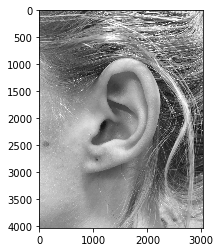

In [ ]:
image_ord = [data_set[0]]
image = process_image(image_ord, size = 200, margin = [500,2500,500,3500])
image = np.asarray(image)
plt.imshow(data_set[0], cmap='gray')
image = image[:,:,:,np.newaxis] 
print(image.shape)

dimension of data set： (772, 200, 200, 1) (772, 195)
39/39 [==============================] - 17s 437ms/step - loss: 5.2865 - accuracy: 0.0013
This is person No.0
These are all other picture of that person


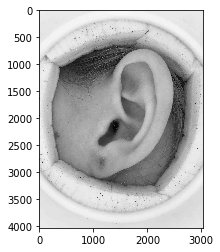

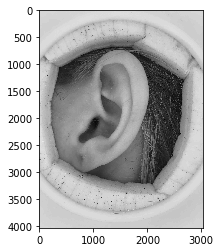

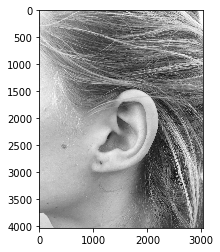

In [ ]:
train(data_final, batch_size = 20,epochs = 1, nb_filters = 64, pool_size = 2, kernel_size = 3,X_target = image)